In [1]:
import rdkit
# from naglmbis.models import load_charge_model
from utility_functions import get_latent_embedding, total_latent_embeddings
from naglmbis.utils import  get_model_weights
import naglmbis
from openff.toolkit.topology import Molecule
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
from naglmbis.models import load_charge_model

# load two pre-trained charge models
charge_model = load_charge_model(charge_model="nagl-v1-mbis")
# load a model trained to scf dipole and mbis charges
charge_model_2 = load_charge_model(charge_model="nagl-v1-mbis-dipole")


In [2]:
test_mol  = Molecule.from_smiles('COC1=CC(CN2CC(C2)NC(CNC3=NN(C4=C3C=C(C(F)(F)F)C=C4)C)=O)=CC=C1')
test_molrd = test_mol.to_rdkit()
dgl_mol_2 = charge_model.return_dgl_molecule(test_molrd)
charge_model.forward(dgl_mol_2)
#this gives us our latent vector
dgl_mol_2.graph.ndata['h']

NameError: name 'charge_model' is not defined

In [4]:
def get_latent_embedding(smiles: str) -> torch.Tensor:
    test_mol  = Molecule.from_smiles(smiles, allow_undefined_stereo=True)
    test_molrd = test_mol.to_rdkit()
    dgl_mol_2 = charge_model.return_dgl_molecule(test_molrd)
    charge_model.forward(dgl_mol_2)
    #this gives us our latent vector
    return dgl_mol_2.graph.ndata['h'], test_molrd

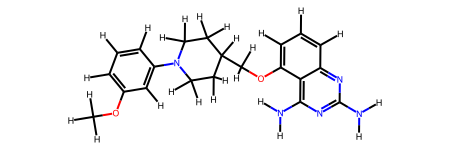

In [ ]:
a, b =  get_latent_embedding(smiles_list[2])
a
b

In [ ]:
latent_embeddings = dgl_mol_2.graph.ndata['h']
latent_embeddings.shape

torch.Size([56, 128])

In [ ]:
total_embedings = torch.empty((1,128), dtype=torch.int64)
total_embedings

tensor([[              0, 140505462719035, 140505279012864, 140505462687978,
         140505462748288, 140505462676496, 140505460416304, 140505459895392,
         140505459906960, 140505462688192, 140505437206384, 140505462743824,
         140505462744016, 140505462703472, 140505462703664, 140505462704464,
         140505462704656, 140505462704848, 140505462705040, 140505437305792,
         140505437305984, 140505437306176, 140505462341248, 140505462410736,
         140505440996528, 140505441228704, 140505283966896, 140505291108288,
         140505291650032, 140505462340176, 140505441314304, 140505462343488,
         140505462001104, 140505462083344, 140505462244608, 140505462244800,
         140505462248640, 140505462248832, 140505440973552, 140505440973744,
         140505441223456, 140505441223648, 140505283806768, 140505283806960,
         140505284296992, 140505284297184, 140505283572496, 140505283572688,
         140505290921760, 140505290921952, 140505462342496, 140505462342688,

In [ ]:
# latent_embeddings = dgl_mol_2.graph.ndata['h']


# Create a dictionary to track unique embeddings and labels
unique_embeddings = {}
atom_labels = {}
smiles_list = ['COC1=CC(CN2CC(C2)NC(CNC3=NN(C4=C3C=C(C(F)(F)F)C=C4)C)=O)=CC=C1',
               'O=C(CCCC(O)=O)NC(CC1)CCC1CCN(CC2)CCN2C3=NC=CC4=C3CCO4',
                'COC1=CC=CC(N2CCC(COC3=C(C(N)=NC(N)=N4)C4=CC=C3)CC2)=C1',
                'O=C1NC2=C(C13CC4=C(C3)C=C(NCCOC5=CC=CC=C5)C=C4)C=CC=N2']
rdkit_mols = []

atom_index = 0
tensors = []
for smiles in smiles_list:
    latent_embedding, test_molrd = get_latent_embedding(smiles)
    tensors.append(latent_embedding)
    for i, atom in enumerate(test_molrd.GetAtoms()):
        atom_type = atom.GetSymbol()  # Get the atom type (C, N, O, etc.)
        embedding = latent_embedding[i].unsqueeze(1)  # Get the embedding for the atom

        # Check if this atom type has been encountered before
        if atom_type not in unique_embeddings:
            unique_embeddings[atom_type] = [embedding]
            atom_labels[atom_index] = f"{atom_type}1"
        else:
            # Compare with existing embeddings for this atom type
            is_unique = True
            for j, unique_embedding in enumerate(unique_embeddings[atom_type]):
                #atol controls the distance
                if torch.all(torch.isclose(embedding, unique_embedding, atol=50)):
                    atom_labels[atom_index] = f"{atom_type}{j+1}"
                    is_unique = False
                    break
            
            if is_unique:
                unique_embeddings[atom_type].append(embedding)
                atom_labels[atom_index] = f"{atom_type}{len(unique_embeddings[atom_type])}"

        # Set the atom label property
        atom.SetProp("atomLabel", atom_labels[atom_index])
        atom_index += 1 

    rdkit_mols.append(test_molrd)    

total_embedings = torch.cat(tensors)

In [ ]:
total_embedings.shape

torch.Size([226, 128])

In [ ]:
atom_labels

{0: 'C1',
 1: 'O1',
 2: 'C2',
 3: 'C3',
 4: 'C2',
 5: 'C1',
 6: 'N1',
 7: 'C4',
 8: 'C4',
 9: 'C4',
 10: 'N2',
 11: 'C5',
 12: 'C4',
 13: 'N2',
 14: 'C2',
 15: 'N1',
 16: 'N3',
 17: 'C2',
 18: 'C3',
 19: 'C2',
 20: 'C3',
 21: 'C6',
 22: 'F1',
 23: 'F1',
 24: 'F1',
 25: 'C2',
 26: 'C3',
 27: 'C1',
 28: 'O2',
 29: 'C3',
 30: 'C2',
 31: 'C3',
 32: 'H1',
 33: 'H1',
 34: 'H1',
 35: 'H2',
 36: 'H1',
 37: 'H1',
 38: 'H1',
 39: 'H1',
 40: 'H1',
 41: 'H1',
 42: 'H1',
 43: 'H3',
 44: 'H1',
 45: 'H1',
 46: 'H3',
 47: 'H1',
 48: 'H1',
 49: 'H2',
 50: 'H1',
 51: 'H1',
 52: 'H1',
 53: 'H2',
 54: 'H1',
 55: 'H2',
 56: 'O2',
 57: 'C5',
 58: 'C7',
 59: 'C8',
 60: 'C7',
 61: 'C5',
 62: 'O3',
 63: 'O4',
 64: 'N2',
 65: 'C4',
 66: 'C7',
 67: 'C7',
 68: 'C7',
 69: 'C7',
 70: 'C3',
 71: 'C7',
 72: 'C1',
 73: 'N1',
 74: 'C4',
 75: 'C4',
 76: 'C4',
 77: 'C4',
 78: 'N1',
 79: 'C2',
 80: 'N1',
 81: 'C2',
 82: 'C3',
 83: 'C2',
 84: 'C3',
 85: 'C4',
 86: 'C4',
 87: 'O1',
 88: 'H2',
 89: 'H2',
 90: 'H1',
 91: 'H1'

In [ ]:
rdkit_mols[0].GetNumAtoms()

56

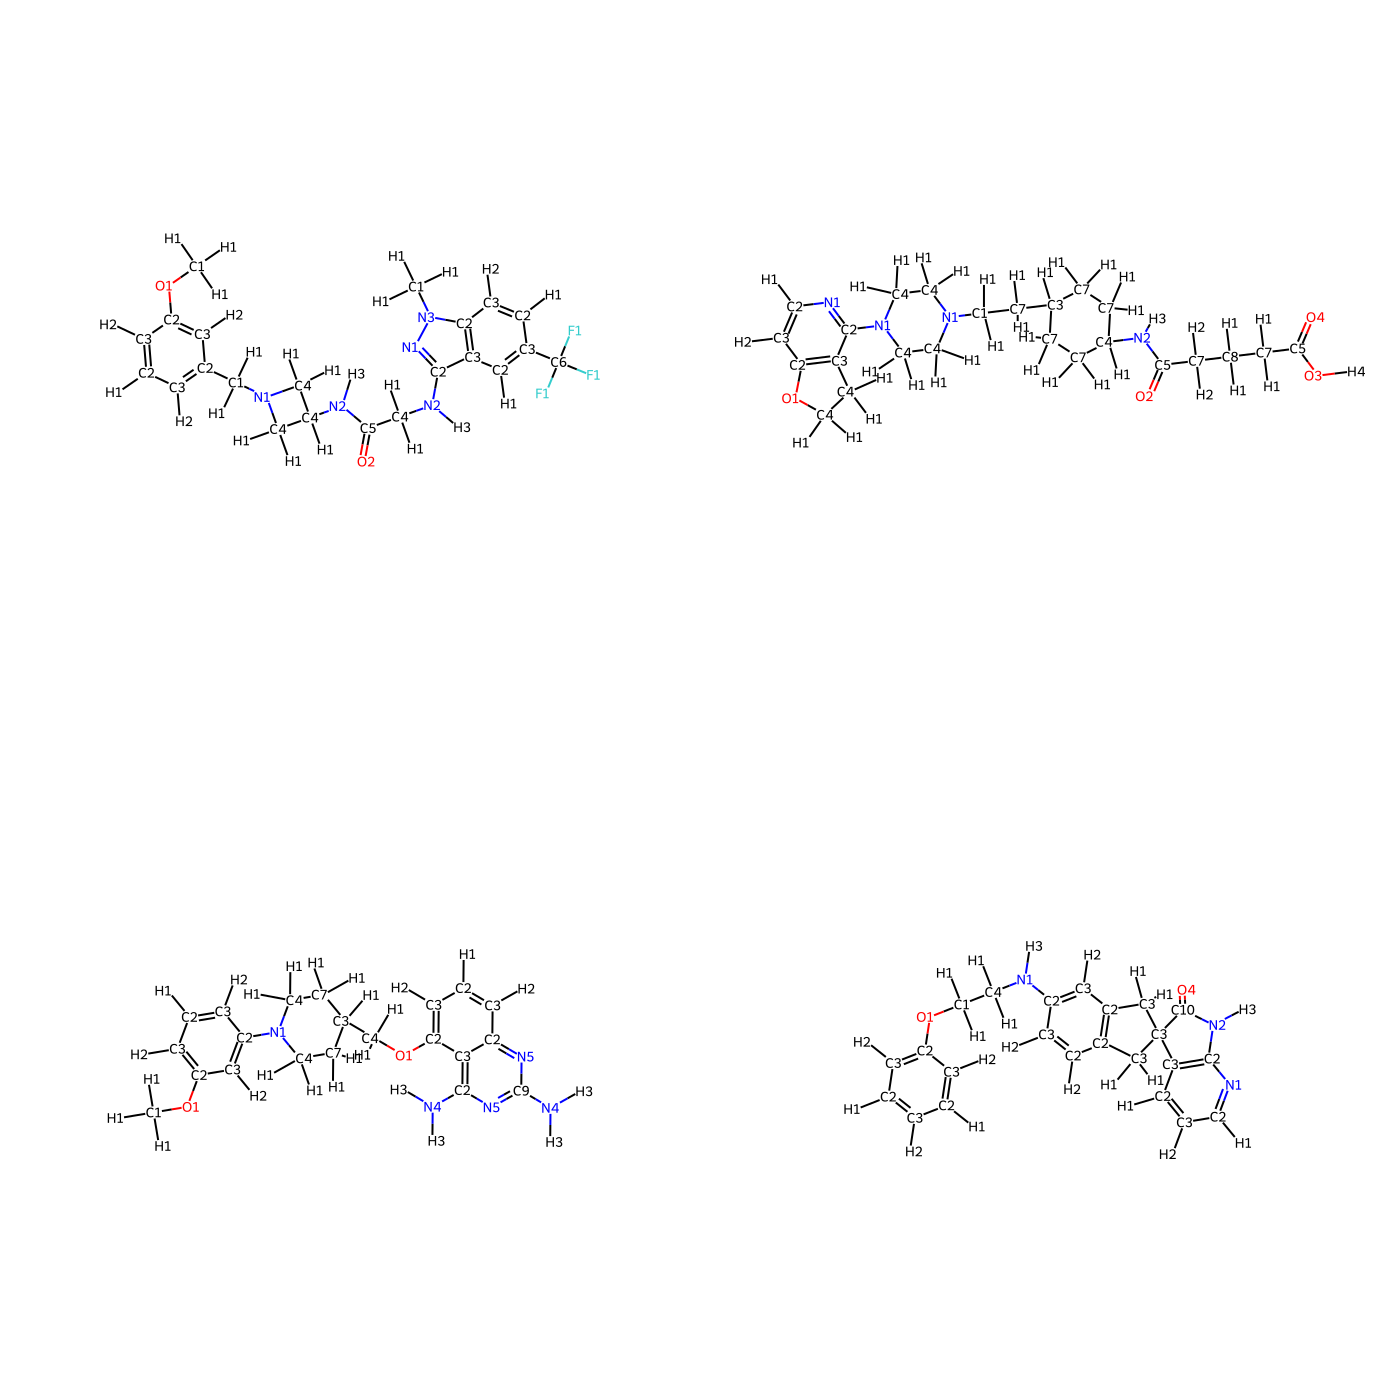

In [ ]:
def molecule_with_labels(mols):
        return Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(700, 700))

# Generate and display the molecule with labels
image = molecule_with_labels(rdkit_mols)
image

In [ ]:
# Convert the embeddings tensor to a numpy array for distance calculations
embeddings = total_embedings.detach().numpy()

# Calculate the pairwise Euclidean distances between embeddings
# cdist returns a matrix of distances between each pair of vectors in the two collections of inputs.
distance_matrix = cdist(embeddings, embeddings, metric='euclidean')

# Initialize the confusion matrix as a pandas DataFrame
# The indices and columns represent unique atom labels
unique_labels = sorted(set(atom_labels.values()))
confusion_matrix = pd.DataFrame(np.zeros((len(unique_labels), len(unique_labels))), index=unique_labels, columns=unique_labels)

# Populate the confusion matrix with aggregated distances
for i, label_i in atom_labels.items():
    for j, label_j in atom_labels.items():
        confusion_matrix.at[label_i, label_j] += distance_matrix[i, j]

# Normalize the values by the number of occurrences to get the average distance
for label in unique_labels:
    count_i = list(atom_labels.values()).count(label)
    for label_j in unique_labels:
        count_j = list(atom_labels.values()).count(label_j)
        confusion_matrix.at[label, label_j] /= (count_i * count_j)

confusion_matrix

,C1,C10,C2,C3,C4,C5,C6,C7,C8,C9,...,H4,N1,N2,N3,N4,N5,O1,O2,O3,O4
C1,111.363880,363.283167,303.218078,284.558237,135.043221,401.417669,428.822480,215.973271,166.045352,365.736748,...,365.498732,320.220291,338.646912,298.301199,368.481857,363.800853,327.408185,401.480936,349.811760,385.503503
C10,363.283167,0.000000,272.472803,367.588345,330.136829,100.734801,205.170686,429.711972,384.610317,145.841456,...,264.587869,414.437701,489.005051,327.043624,522.587907,431.866290,452.481782,484.929507,502.532720,431.344706
C2,303.218078,272.472803,93.912855,165.193052,232.106659,333.183605,382.534605,293.564588,282.154153,217.192877,...,208.243953,218.010638,310.123805,122.645755,355.207790,238.211331,285.593874,301.057756,334.671413,235.129281
C3,284.558237,367.588345,165.193052,97.552066,212.744832,422.878155,470.366805,211.709583,229.160115,320.808052,...,286.284961,148.735393,211.446965,138.183329,258.161302,156.934119,232.431527,235.507470,256.225838,188.590447
C4,135.043221,330.136829,232.106659,212.744832,81.195271,377.382040,413.259835,176.546147,139.751809,322.286697,...,308.019198,251.599311,286.807600,223.344796,329.610218,298.534658,270.149171,342.073937,304.224116,317.528981
C5,401.417669,100.734801,333.183605,422.878155,377.382040,66.323921,188.617325,471.956716,422.932628,181.514752,...,317.649505,467.218765,534.339984,387.417698,565.463269,485.027390,499.607645,533.355379,546.704698,485.947987
C6,428.822480,205.170686,382.534605,470.366805,413.259835,188.617325,0.000000,509.796949,455.629407,229.433219,...,360.713447,512.562707,574.280799,437.030734,608.051897,532.896727,542.298568,569.322119,592.562371,531.139260
C7,215.973271,429.711972,293.564588,211.709583,176.546147,471.956716,509.796949,61.247904,110.925434,408.408314,...,385.903944,228.148372,207.740127,262.339349,240.219821,273.999478,258.424687,308.398890,258.563002,310.161474
C8,166.045352,384.610317,282.154153,229.160115,139.751809,422.932628,455.629407,110.925434,0.000000,372.310221,...,368.395011,255.686487,263.149725,261.987771,301.287562,308.412828,271.096924,338.715336,298.158339,334.281057
C9,365.736748,145.841456,217.192877,320.808052,322.286697,181.514752,229.433219,408.408314,372.310221,0.000000,...,249.889225,365.386983,445.306104,276.153341,478.441588,377.232349,416.426476,431.071792,463.543139,373.326794


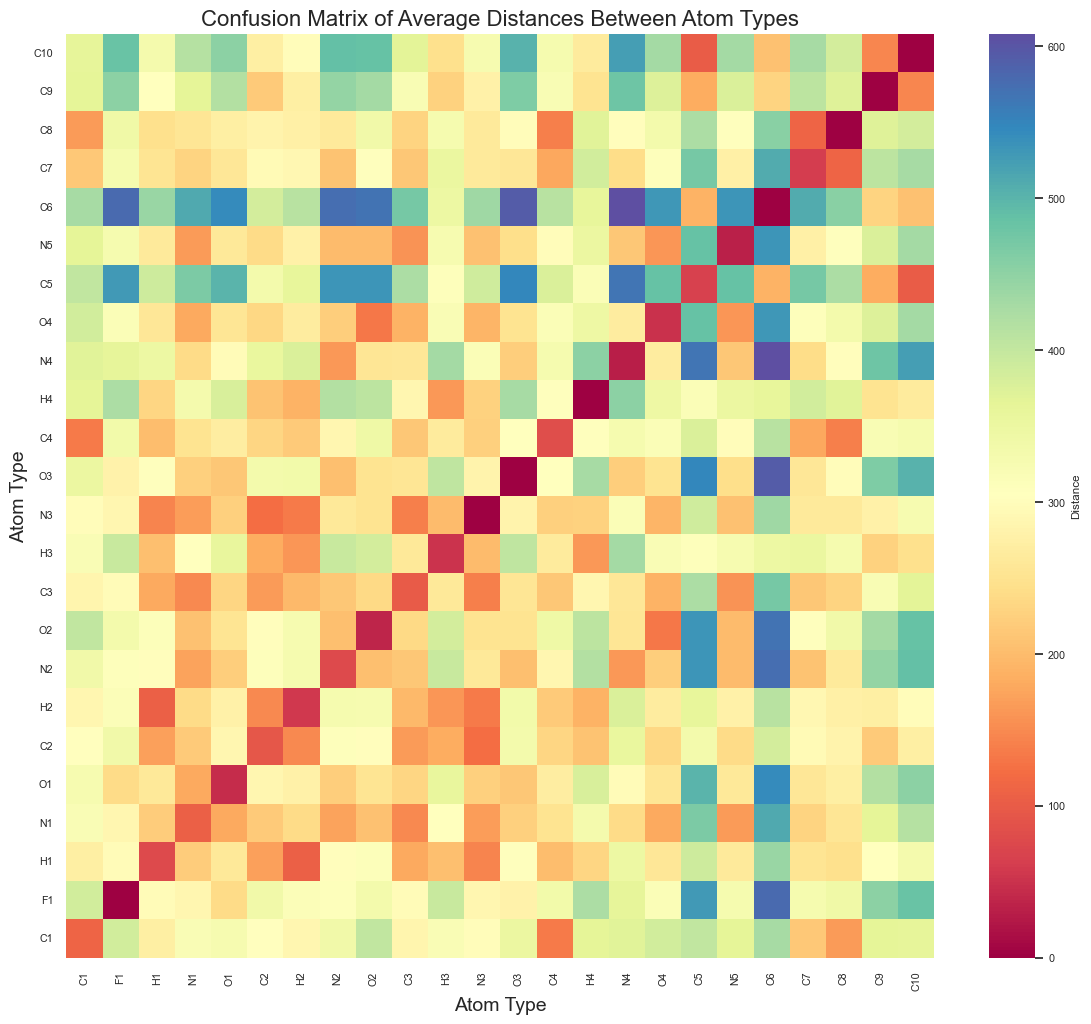

In [ ]:
# Convert the DataFrame to a sorted matrix
sorted_labels = sorted(confusion_matrix.columns, key=lambda x: int(x[1:]))  # Sort labels by numerical order
sorted_matrix = confusion_matrix.loc[sorted_labels, sorted_labels]

# Plot configuration
plt.figure(figsize=(14, 12))  # Increase figure size
sns.set(font_scale=0.7)  # Adjust to scale down text size if needed

# Create a heatmap
ax = sns.heatmap(sorted_matrix.reindex(index=sorted_matrix.index[::-1]), annot=False, cmap='Spectral', cbar_kws={'label': 'Distance'})
plt.title('Confusion Matrix of Average Distances Between Atom Types', fontsize=16)
plt.xlabel('Atom Type', fontsize=14)
plt.ylabel('Atom Type', fontsize=14)

# Rotate tick labels for better visibility
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
